## Stanley Mean Temperature 

In [1]:
from scripts.fetch import get_data
from scripts.stats import adf_test, kpss_test
from scripts.plot import plot_df, plot_acf_pacf, plot_seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller


## Data preprocessing
- Using interpolation to impute missing values
- converting and combining temporal columns

In [2]:
df = get_data(filename="00_raw_output.csv", station="STY") # Download 
df = pd.read_csv("./data/00_raw_output.csv")

# Data preprocessing
n = len(df.temperature)
df = df.replace('***', np.nan)
print("\nRaw data: ")
print(f"There are {n - df.temperature.count()} empty temperature values out of {n} data points")
print(df.head())

# Combine temporal columns into one
df['date'] = pd.to_datetime( df[['year', 'month', 'day']])
print(f"There are {len(df.date) - df.date.nunique()} duplicated dates")

# Extract useful columns
df = df.set_index('date').asfreq('D')
df = df["temperature"]
df = df.astype(float)

# interpolate temperature

df.interpolate("time", inplace=True)
print("\nAfter imputation: ")
print(f"There are {len(df) - df.count()} empty temperature values out of {len(df)} data points")
df.head()

df.to_csv("./data/01_processed_output.csv")


Raw data: 
There are 26 empty temperature values out of 4676 data points
   year  month  day temperature completeness
0  2009      6   12        26.2            C
1  2009      6   13        28.0            C
2  2009      6   14        27.4            C
3  2009      6   15        26.8            C
4  2009      6   16        27.9            C
There are 0 duplicated dates

After imputation: 
There are 0 empty temperature values out of 4676 data points


## Data visualization
Training data: 5 years from 2017 to 2022

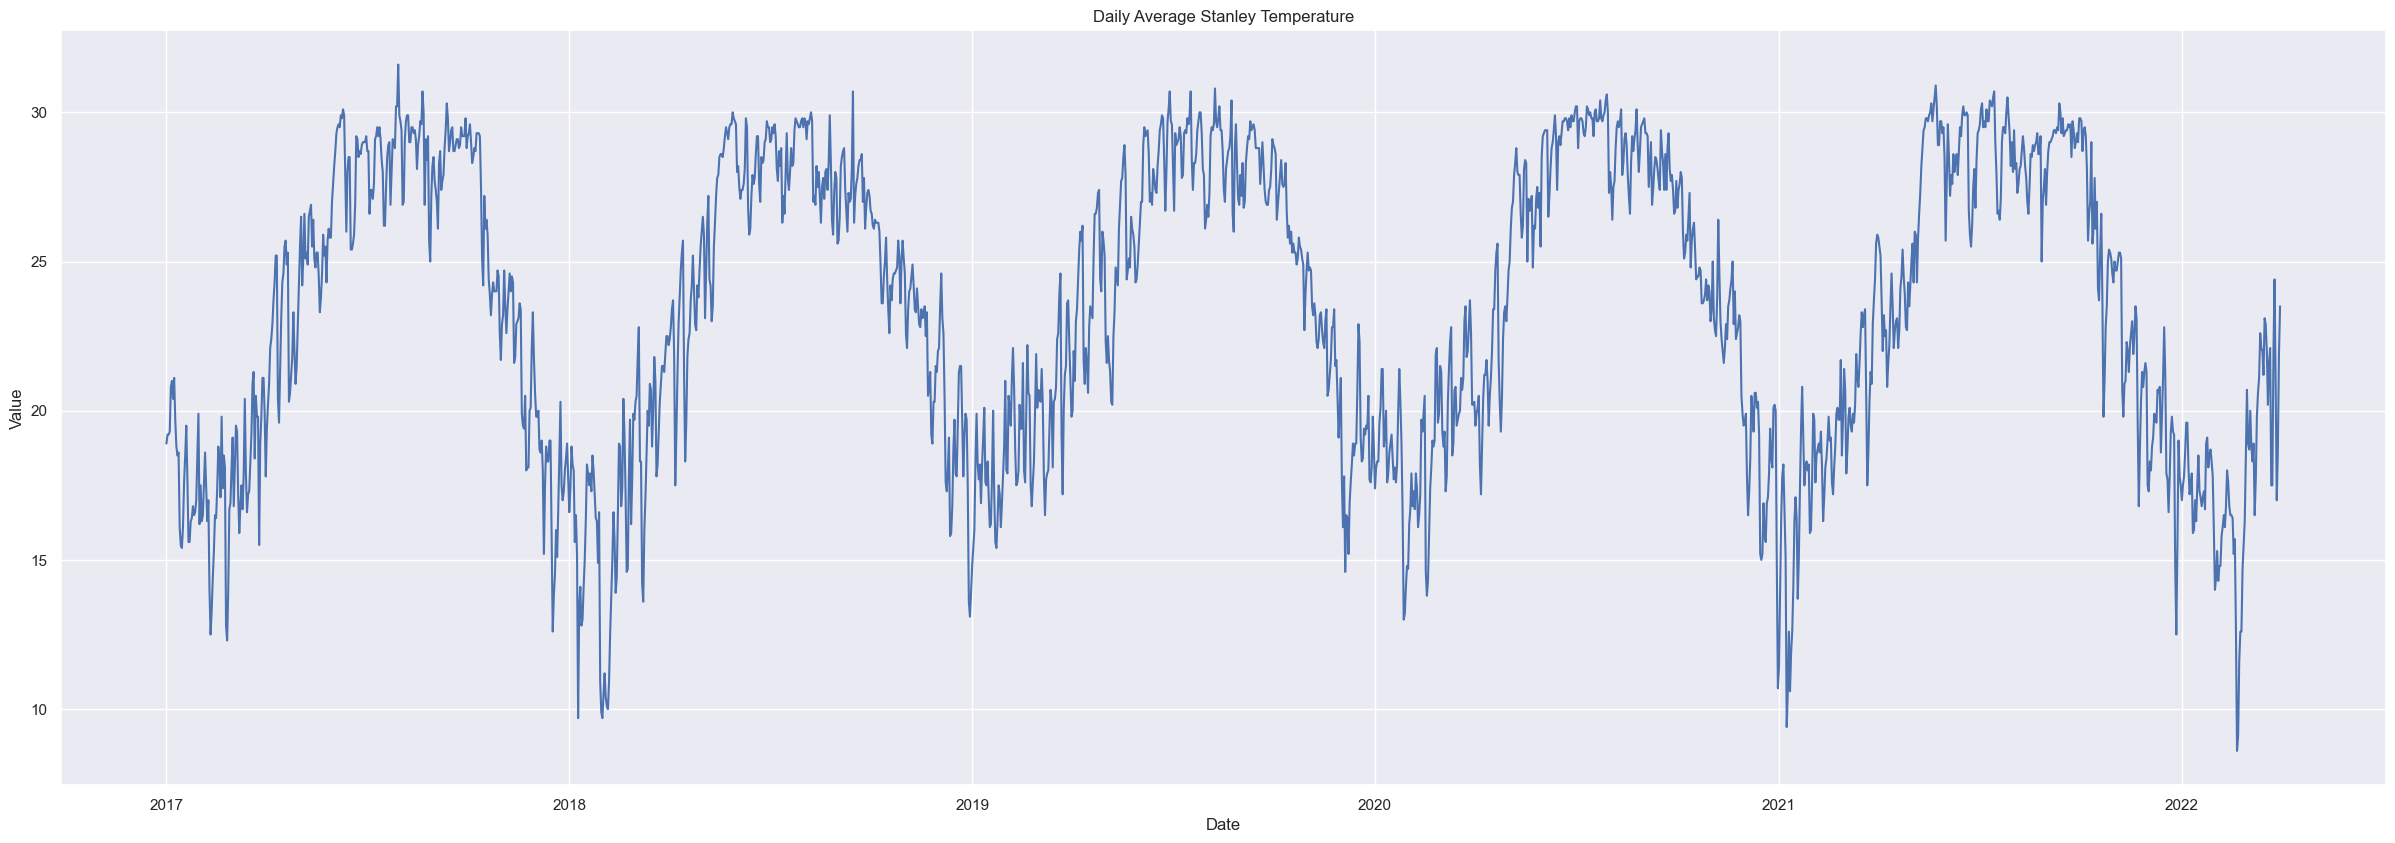

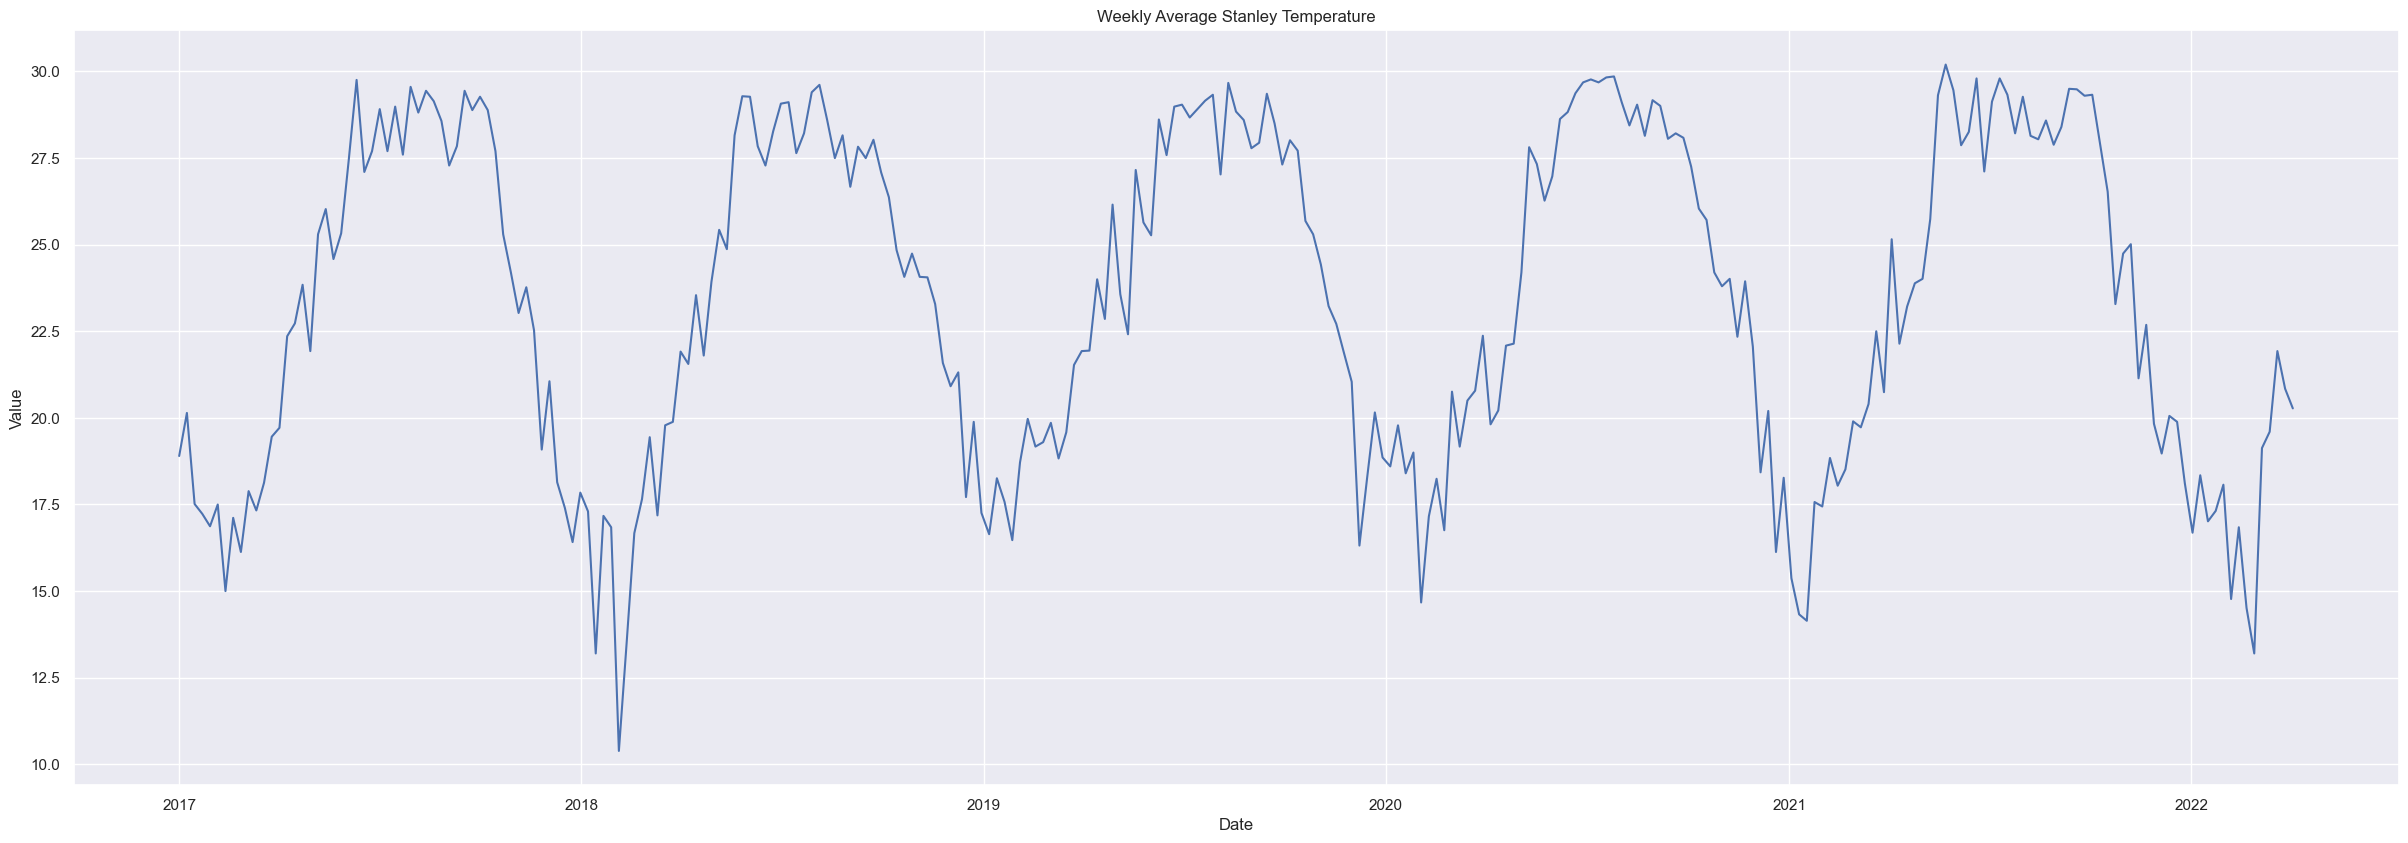

In [3]:
# Draw Plot
sns.set_theme()

start="2017-01-01"
range_df = df.loc[start:]
df_week = range_df.resample('W').mean()

# sns.lineplot(data=range_df,x=range_df.index,y=range_df.values)
plot_df(range_df, title='Daily Average Stanley Temperature')  
plot_df(df_week, title='Weekly Average Stanley Temperature')  

## Stationary test
ADF test:
the null hypothesis is the time series possesses a unit root and is non-stationary. 
So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [4]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

ad_test(df_week)

1. ADF :  -6.847509132578087
2. P-Value :  1.7276650566678146e-09
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 259
5. Critical Values :
	 1% :  -3.4558530692911504
	 5% :  -2.872764881778665
	 10% :  -2.572751643088207


In [8]:
adf = adf_test(range_df)
adf2 = adf_test(df_week)
print("")
# kpss = kpss_test(df_week)

1. ADF Statistic: -2.546956903859301
2. Critical Values :
	 1% :  -3.4337927694028645
	 5% :  -2.8630607871429614
	 10% :  -2.567579609288358
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression: 1902
5. P-value: 0.10446308120858949 > 0.05, H0 not rej
	Time series is not stationary
1. ADF Statistic: -6.847509132578087
2. Critical Values :
	 1% :  -3.4558530692911504
	 5% :  -2.872764881778665
	 10% :  -2.572751643088207
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 259
5. P-value: 1.7276650566678146e-09 < 0.05, H0 rej
	Time series is stationary



## Sample PACF and ACF
SACF decays slowly 

SPACF cuts off at around 2nd lag

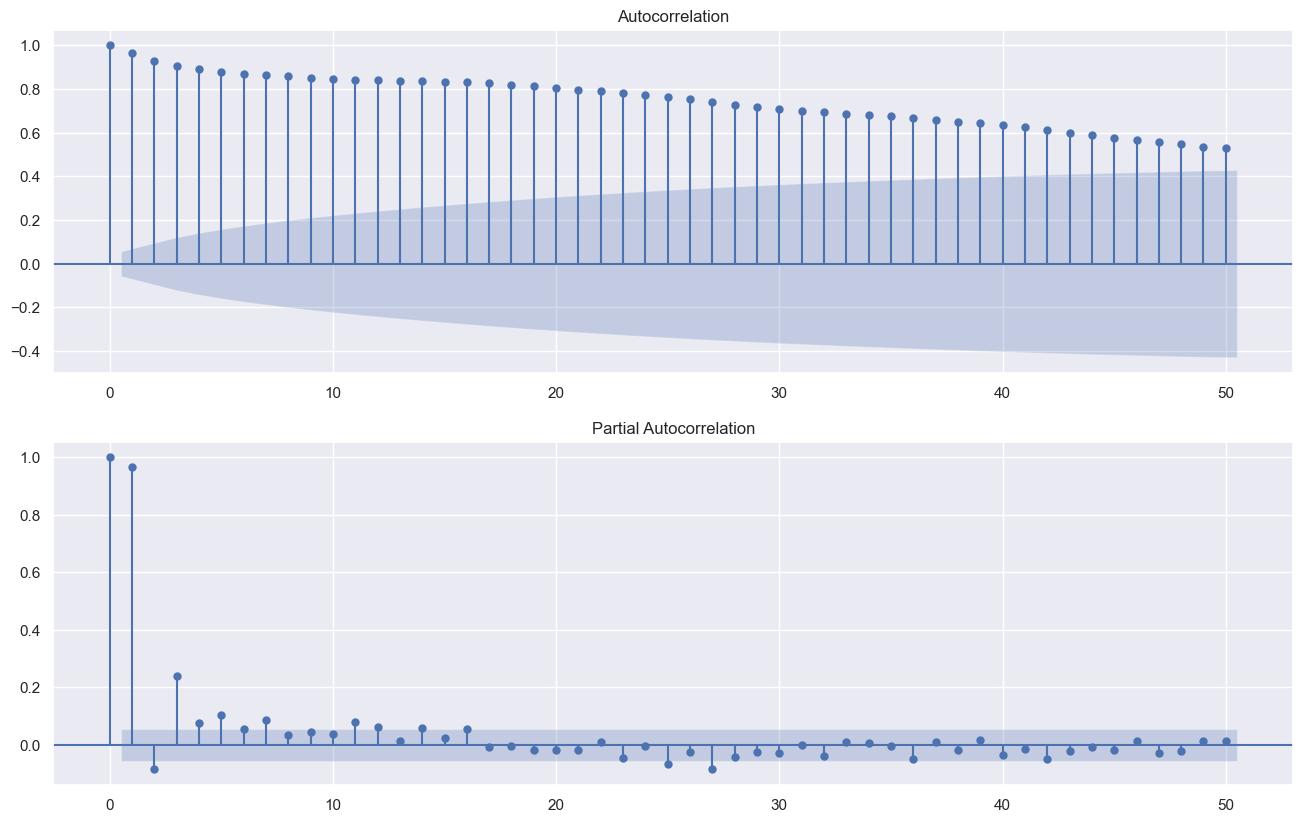

In [17]:
plot_acf_pacf(range_df)

Sinusoidal ACF plot implies unit root (non-stationarity) and seasonality 

PACF cuts off at lag 3

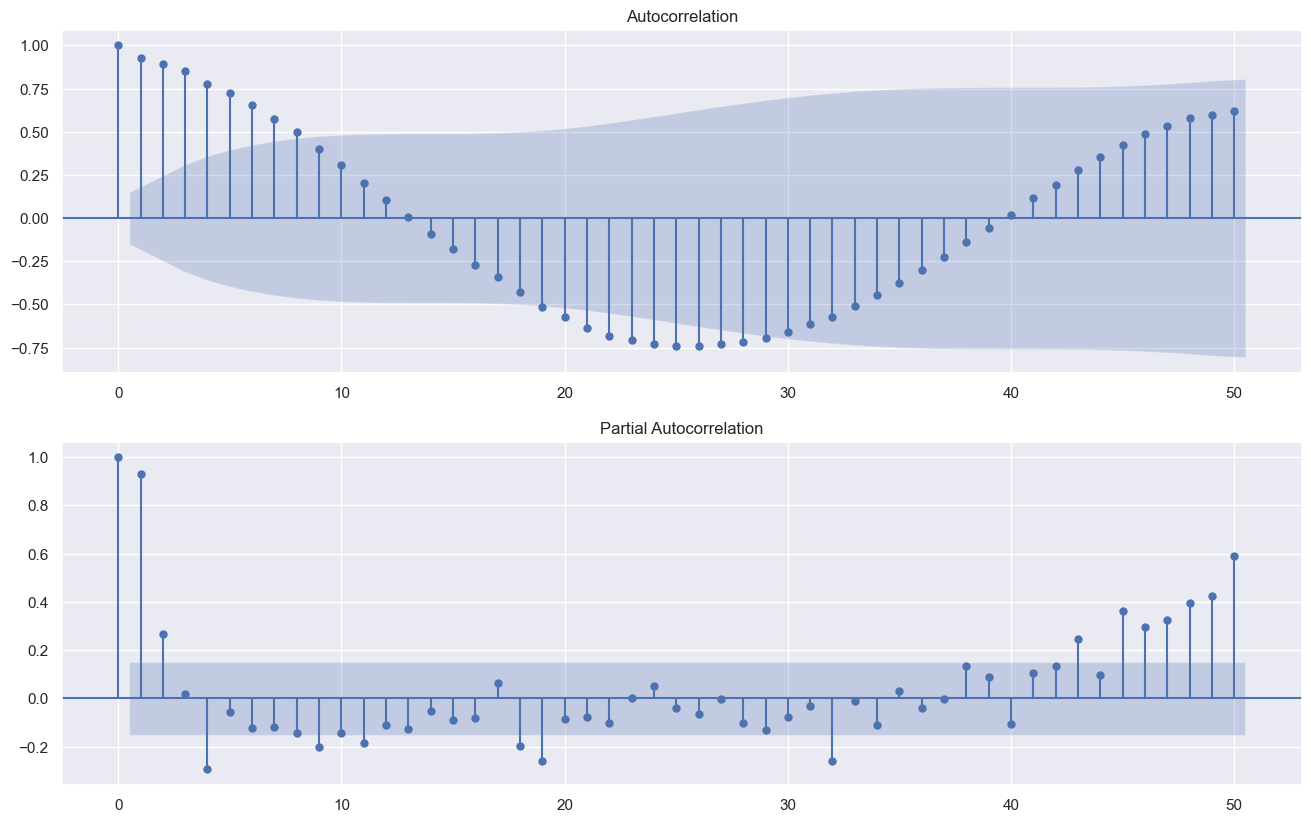

In [18]:
plot_acf_pacf(df_week)

## Seasonal Decomposition


In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose_result_mult = seasonal_decompose(range_df, model="additive")
decompose_result_weekly = seasonal_decompose(df_week, model="multiplicative")
# plt.figure(figsize=(30, 30))

# fig = plot_seasonal_decompose(decompose_result_mult, dates=range_df.index)
fig2 = plot_seasonal_decompose(decompose_result_weekly, dates=df_week.index)
# fig.show()
fig2.show()

### Differencing


In [20]:
df_diff_1 = df_week.diff(periods=52)[52:]
decompose_result_1 = seasonal_decompose(df_diff_1, model="additive")
seasonal = decompose_result_1.seasonal
plot_seasonal_decompose(decompose_result_1, dates=df_diff_1[-52:].index)

# df_diff_2 = df_diff_1.diff(periods=7)[7:]
# plot_df(df_diff, title='Daily Average Stanley Temperature')  
# decompose_result_2 = seasonal_decompose(df_diff_2, model="additive")
# plot_seasonal_decompose(decompose_result_2, dates=df_diff_2[:].index)

#### ACF/PACF plots
- ACF decays exponentially now. The differenced time series appears to be stationary now
- PACF cuts off at 4th lag

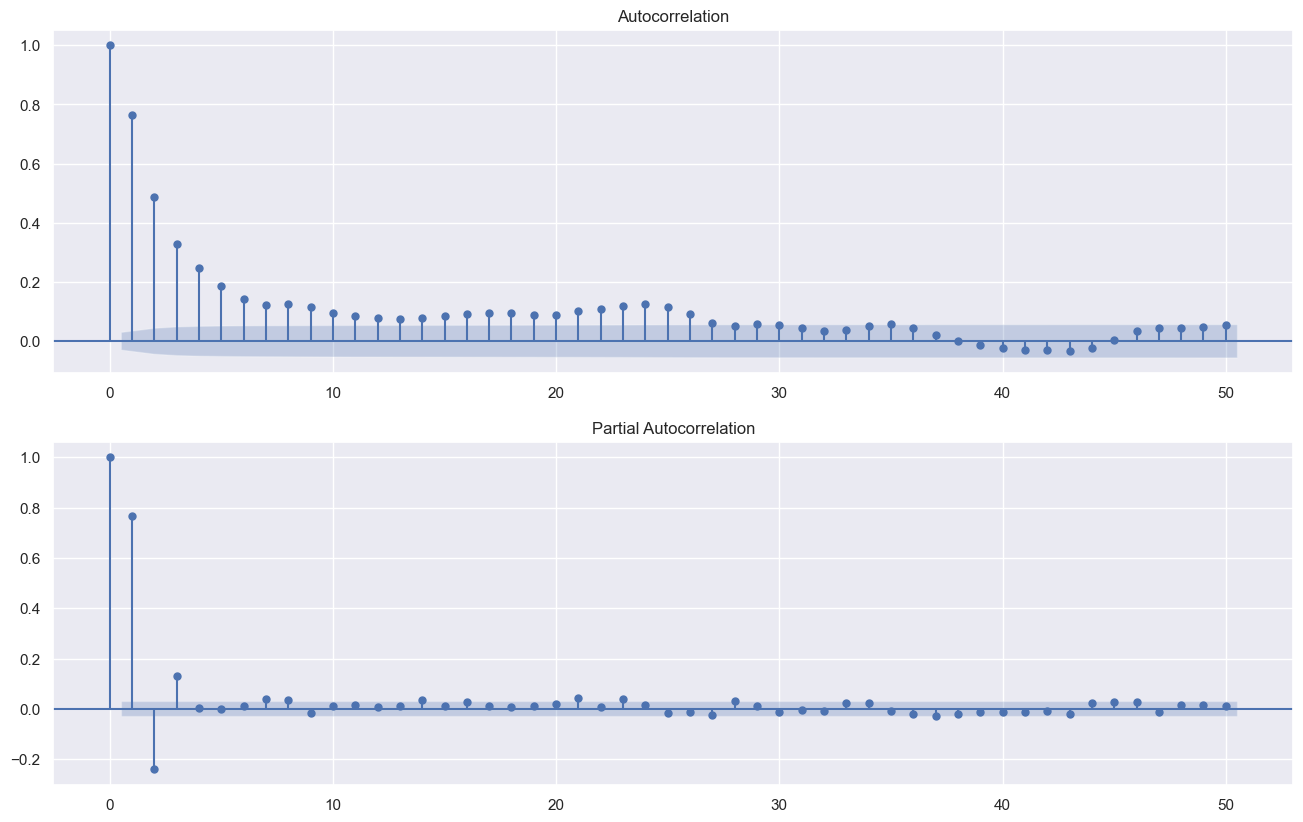

In [114]:
plot_acf_pacf(df_diff_1)

After Differencing:
- there appears to be weekly seasonality


[Text(0.5, 1.0, 'Seasonal Component Plot (2022 daily)')]

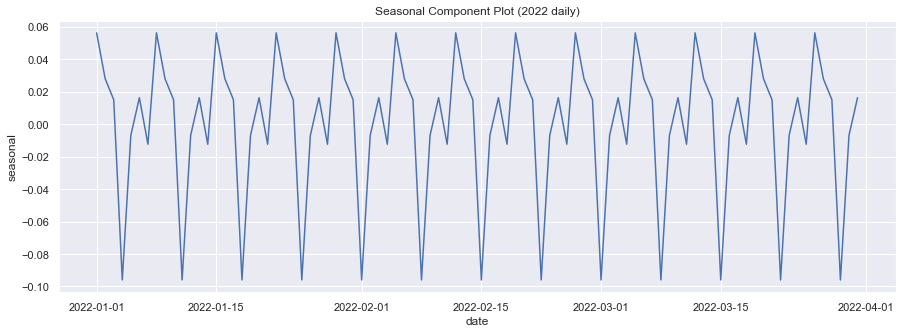

In [112]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=seasonal["2022-01-01":])
plt.gca().set(title="Seasonal Component Plot (2022 daily)")
